# Simple Machine Learining Models

Input: single principal component based on all 15 indicators 

Output: optimal max-shape portfolio with tight restrictions for the next period

In [17]:
import numpy as np

import os
os.chdir(os.path.expanduser('../data'))

from dotenv import load_dotenv
load_dotenv()

from DataProvider import DataProvider

In [18]:
data_provider = DataProvider()
x = data_provider.get_formatted_features(flatten=True)
y = data_provider.get_formatted_targets()
x_train, y_train, _, _, x_test, y_test = data_provider.train_train_split(x, y, with_val=False)

c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


## Random Forest

In [19]:
from sklearn.ensemble import RandomForestRegressor

In [20]:
regressor_random_forest = RandomForestRegressor(n_estimators=32,
                                                random_state=42)
regressor_random_forest.fit(x_train, y_train)

RandomForestRegressor(n_estimators=32, random_state=42)

Checking example predictions

In [21]:
predictions = regressor_random_forest.predict(x_test)

In [22]:
predictions[0].round(3)

array([0.483, 0.061, 0.068, 0.031, 0.029, 0.03 , 0.025, 0.024, 0.01 ,
       0.01 , 0.016, 0.014, 0.013, 0.014, 0.015, 0.011, 0.011, 0.007,
       0.034, 0.013, 0.017, 0.015, 0.012, 0.01 , 0.012, 0.007, 0.009])

In [23]:
y_test[0]

array([0.576, 0.046, 0.075, 0.023, 0.02 , 0.039, 0.017, 0.016, 0.007,
       0.008, 0.02 , 0.005, 0.02 , 0.02 , 0.004, 0.002, 0.002, 0.002,
       0.024, 0.025, 0.02 , 0.012, 0.006, 0.003, 0.004, 0.002, 0.002])

Checking portfolios to match 1.0

In [24]:
preditions_sum = predictions.sum(axis=1)
preditions_sum

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1.])

In [25]:
preditions_sum = preditions_sum.reshape(predictions.shape[0], 1)
predictions = np.divide(predictions, preditions_sum)

In [26]:
predictions.sum(axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1.])

## Gradient Boosting

In [27]:
import xgboost as xgb

In [28]:
regressor_xg_boosting = xgb.XGBRegressor(n_estimators=32,
                                         random_state=42)
regressor_xg_boosting.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=32, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [29]:
xg_boost_predictions = regressor_xg_boosting.predict(x_test)
xg_boost_predictions.sum(axis=1)

array([1.0030767 , 0.9917792 , 0.9357767 , 1.0178331 , 0.9615522 ,
       0.91168237, 1.0040809 , 0.9583615 , 1.0287585 , 0.9777244 ,
       1.0269078 , 1.0342493 , 1.1105287 , 0.99334836, 1.049683  ,
       1.0520517 , 1.1053882 , 1.0479219 , 1.1251446 , 1.2053611 ,
       1.2165872 , 1.2159084 , 1.1871425 , 1.1881031 , 1.1816016 ,
       1.0543163 , 1.0667065 , 1.0656716 , 1.0029435 , 1.0857716 ,
       1.231989  , 1.1802882 , 1.0978665 , 1.0735667 , 1.0478541 ,
       1.073018  , 1.1031566 , 1.0297482 , 1.1448002 , 1.1328926 ,
       1.100402  , 1.1377176 , 1.122726  , 1.0751317 , 1.105915  ,
       1.1028483 , 1.1172603 , 1.0154785 , 1.0804553 , 1.0645506 ,
       1.0471722 , 1.0733615 , 1.0200043 , 1.0277796 , 1.0778561 ,
       1.0440099 , 1.008969  , 0.93403035], dtype=float32)

In [30]:
xg_boost_preditions_sum = xg_boost_predictions.sum(axis=1).reshape(xg_boost_predictions.shape[0], 1)
xg_boost_predictions = np.divide(xg_boost_predictions, xg_boost_preditions_sum)

In [31]:
xg_boost_predictions.sum(axis=1).round(3)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1.], dtype=float32)

## Backtesting

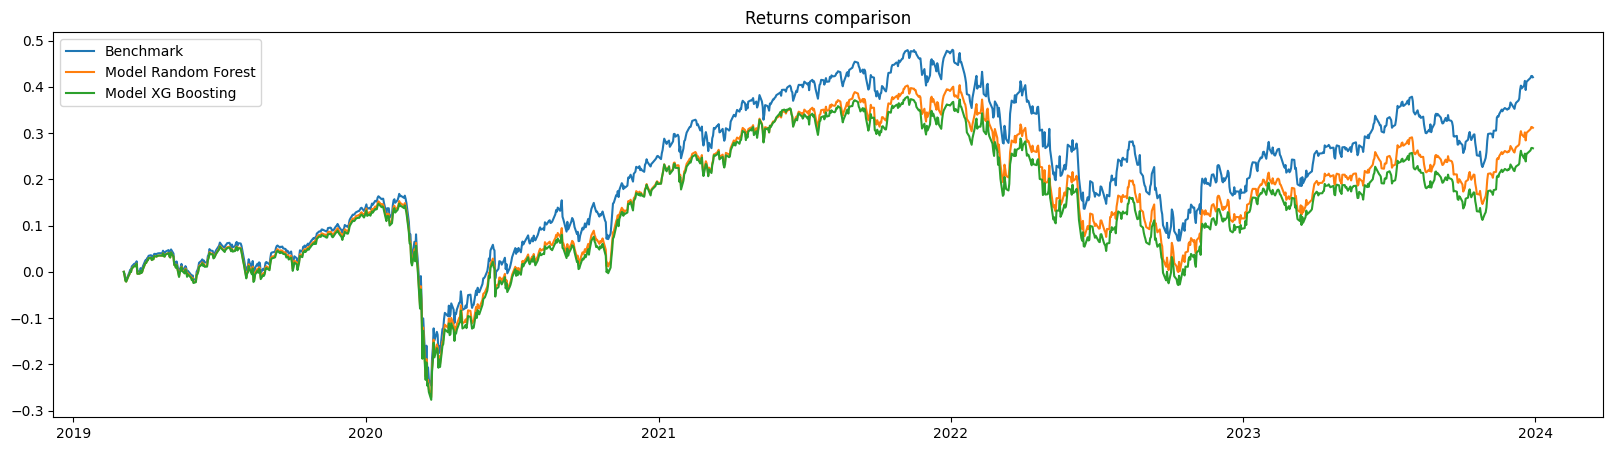

,Annual Returns,Annual Volatility,Sharpe Ratio,Sortino Ratio,Max Drawdown,Max Time Under Water,Calmar Ratio,Information Ratio
Benchmark,0.076754,0.203326,0.377494,0.442047,-0.354829,500.0,0.216313,0
Model Random Forest,0.058538,0.20254,0.28902,0.33541,-0.367771,493.0,0.15917,-0.711969
Model XG Boosting,0.05101,0.203263,0.250958,0.291798,-0.369615,538.0,0.138009,-0.781791


In [32]:
from helper_functions import run_full_backtesting

models = {
    'Model Random Forest': regressor_random_forest,
    'Model XG Boosting': regressor_xg_boosting
}

df_results = run_full_backtesting(data_provider, x_test, models)
df_results